### Extract combined data

In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.signal
from pathlib import Path
import subprocess

In [ ]:

def resample_rolling_mean(data, previous_sr, new_sr):
    """Function to calculate moving average over the passed data
    """
    if previous_sr == new_sr:
        return data
    number_of_samples = int(round(len(data) * float(new_sr) / previous_sr))
    data = scipy.signal.resample(data, number_of_samples)
    return data

def resample_sample_and_hold(data, previous_sr, new_sr):
    """Resample data to a given re-sampling rate"""
    if previous_sr == new_sr:
        return data

    if new_sr < previous_sr:
        interval = int(previous_sr / new_sr)
        # Downsampling: take values at specific intervals
        resampled_data = data[::interval]
    else:
        # Upsampling: use sample and hold
        factor = int(new_sr / previous_sr)
        resampled_data = np.repeat(data, factor)[:int(len(data) * factor)]

    return resampled_data


def align_data(data_list, original_sr_list):
    """Aligns the data to the same length by resampling."""
    max_length = max(len(data) for data in data_list)
    aligned_data = []
    for data, previous_sr in zip(data_list, original_sr_list):
        if len(data) < max_length:
            # Resample the data to the maximum length
            new_sr = max_length * previous_sr / len(data)

            # data = resample_sample_and_hold(data, previous_sr, new_sr)
            data = resample_rolling_mean(data, previous_sr, new_sr)
        aligned_data.append(data)
    return aligned_data

In [ ]:
# Paths
participants_folder_name = '20200415'
participants_folder = os.path.abspath(participants_folder_name)
combined_folder = os.path.join(participants_folder, 'combined')
metadata_file = Path(participants_folder).parent.parent / 'Coswara-Data' /  participants_folder_name / f'{participants_folder_name}.csv'
if not metadata_file.exists():
    raise FileNotFoundError(f"Metadata file {metadata_file} does not exist.")

In [ ]:
# ['breathing-deep.wav', 'breathing-shallow.wav', 'cough-heavy.wav',
#  'cough-shallow.wav', 'counting-fast.wav', 'counting-normal.wav',
#  'vowel-a.wav', 'vowel-e.wav', 'vowel-o.wav']

# NOTE: Assuming a 48kHz sampling rate for all waveforms (see Fig. 5b in https://www.nature.com/articles/s41597-023-02266-0)
waveform_sampling_rates = {
    'breathing-deep.wav': 48000,
    'breathing-shallow.wav': 48000,
    'cough-heavy.wav': 48000,
    'cough-shallow.wav': 48000,
    'counting-fast.wav': 48000,
    'counting-normal.wav': 48000,
    'vowel-a.wav': 48000,
    'vowel-e.wav': 48000,
    'vowel-o.wav': 48000
}

df = pd.read_csv(metadata_file)
labels = df['covid_status']
labels_map = {label: i for i, label in enumerate(labels.unique())}

individuals = [name.replace('_combined.npz', '') for name in os.listdir(combined_folder) if name.endswith('npz')]

for individual in individuals:

    # Load the waveform data for the individual
    data_npz = np.load(os.path.join(combined_folder, f'{individual}_combined.npz'))
    class_names = data_npz.files
    waveform_data = [data_npz[name] for name in class_names]

    # Align the data and create a DataFrame
    aligned_data = align_data(waveform_data, [waveform_sampling_rates[waveform_name] for waveform_name in class_names])
    data = np.column_stack(aligned_data)
    indiv_df = pd.DataFrame(data, columns=[filename.replace('.wav', '') for filename in class_names])

    # add participant_id and covid_status
    label = df[df['id'] == individual]['covid_status'].values[0]
    indiv_df['covid_status'] = labels_map[label]
    indiv_df['participant_id'] = individual

    indiv_df.to_csv(os.path.join(combined_folder, f'{individual}_aligned.csv'), index=False)

In [35]:
data_npz.files

['breathing-deep.wav',
 'breathing-shallow.wav',
 'cough-heavy.wav',
 'cough-shallow.wav',
 'counting-fast.wav',
 'counting-normal.wav',
 'vowel-a.wav',
 'vowel-e.wav',
 'vowel-o.wav']

In [ ]:
def extract_raw():
    workdir = os.path.dirname(os.path.abspath(__file__))

    coswara_data_dir = os.path.join(workdir, "Coswara-Data")
    if not os.path.exists(coswara_data_dir):
        raise FileNotFoundError("COSWARA dataset directory not found. Please run the download_coswara_dataset function first.")

    extracted_data_dir = os.path.join(coswara_data_dir, 'Extracted_data')
    # get the list of directories to extract
    dirs_to_extract = [directory for directory in os.listdir(coswara_data_dir) 
                       if os.path.isdir(os.path.join(coswara_data_dir, directory)) and directory != 'Extracted_data']

    for d in dirs_to_extract:
        p = subprocess.Popen('cat {}/{}/*.tar.gz.* |tar -xvz -C {}/'.format(coswara_data_dir, d, extracted_data_dir), shell=True)
        p.wait()

### Plot waveforms for one individual

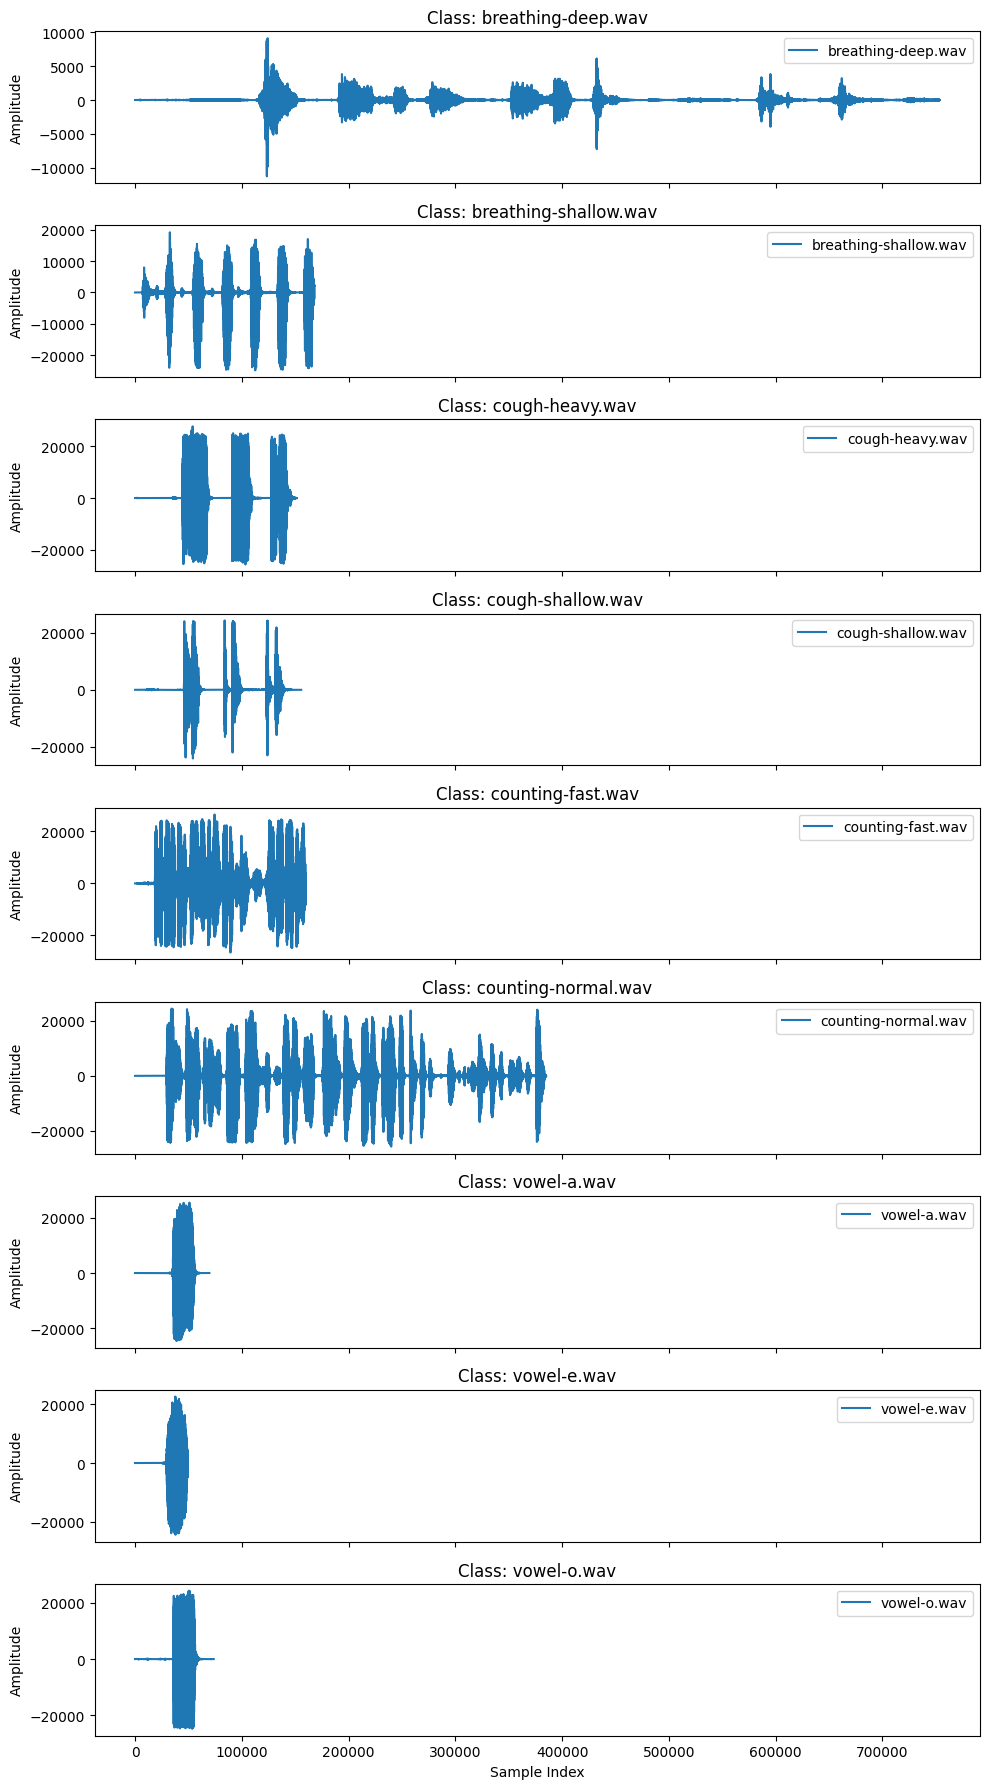

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Path to the folder containing combined data
combined_folder = "20200415/combined"

# Load the first individual's data
individual_files = os.listdir(combined_folder)
if not individual_files:
    print("No combined files found.")
    exit()

first_individual_file = os.path.join(combined_folder, individual_files[0])
waveform_data = np.load(first_individual_file)

# Extract class names and corresponding waveforms
class_names = list(waveform_data.files)
waveforms = [waveform_data[name] for name in class_names]

# Plot each waveform
fig, axes = plt.subplots(len(waveforms), 1, figsize=(10, len(waveforms) * 2), sharex=True)
if len(waveforms) == 1:
    axes = [axes]  # Ensure axes is iterable even for a single plot

for i, (waveform, class_name) in enumerate(zip(waveforms, class_names)):
    axes[i].plot(waveform, label=class_name)
    axes[i].set_title(f"Class: {class_name}")
    axes[i].set_ylabel("Amplitude")
    axes[i].legend(loc="upper right")

# Add a common X-axis label
plt.xlabel("Sample Index")
plt.tight_layout()
plt.show()
